# Experiment tracking in ML

References: [gitlab.com/Neimv](https://gitlab.com/neimv/mlops/-/blob/main/lessons_weeks/notes_2.md), [github.com/Qfl3x](https://gist.github.com/Qfl3x/ccff6b0708358c040e437d52af0c2e43), [github.com/BPrasad123](https://github.com/BPrasad123/MLOps_Zoomcamp/tree/main/Week2)

## What is experiment tracking?

Important concepts in the first stages of a ML project:
- **ML experiment**: is a process of building an ML model.
- **Experiment run**: every time the ML experiment is evaluated. Here we observe parameters, hyperparameters and data behaviour.
- **Artifacts**: any file that is associated with the Experiment run (model, datasets, visualizations, configuration files...). Artifacts represent the tangible results or outputs of an experiment.
- **Experiment metadata**: captures information about the experiment itself and the runs within that experiment (experiment name, description, start and end time, parameters used, metrics recorded, and tags associated with each run). Metadata provides the context and summary of the experiment's execution and outcomes.

**Experiment tracking** is the process to save relevant information of the experiment (e.g. source code, environment, data, model, hyperparameter, metrics) so that we can keep track of the information from multiple experiments. Experiment tracking insures reproducibility, organization  and optimization.

## How do keep track?

At a very basic level one might use spreadsheets (e.g. MS Excel) to track the information manually. However, that is error prone, difficult to maintain long term, does not provide a standard format for new developers, and makes collaboration much harder.

Is there are a better way of achieving this? Yes, there are many open source and proprietary tools that can be used: MLflow, Neptune, Weights and Biases. Here we are going to focus on MLflow.

## What is MLflow?
MLflow is an open-source platform (originally developed by Databricks and later maintained by a larger community) that addresses all the aspects of entire machine learning life cycle including tracking, reproducibility, deployment and storage.

Here we will be only using MLflow to keep track of different versions of the ML code and models, and to log and compare different experiments.

MLflow provides four components to help manage the ML workflow:
- **MLflow Tracking** allows you to log and track experiments, parameters, metrics, and artifacts via an API and UI. It helps you keep a record of different runs and compare their results.
- **MLflow Models** provides a standardized format for packaging and deploying ML models. It allows you to save and load models in various formats, such as Python functions, serialized formats (e.g., pickle), or containerized formats (e.g., Docker images).
- **MLflow Registry** is a centralized model repository that allows you to store, track, and manage different versions of your models. It acts as a catalog or hub for storing and organizing models, making it easier to deploy, share, and reproduce models across different environments and teams.
- **MLflow Projects** (not used here): enables you to package your code and dependencies in a reusable format. It provides a standard way to organize and execute your ML code across different environments. Each project is simply a directory with code or a Git repository, and uses a descriptor file (e.g. .yaml) to specify its dependencies and how to run the code.

## Running MLflow

Install the required packages listed in requirements.txt file.
```console
(mlops-zoomcamp) user@pc:~$ pip install -r requirements.txt
```
To launch MLflow:
```console
(mlops-zoomcamp) user@pc:~$ mlflow ui
```
To access MLflow open http://127.0.0.1:5000 in your browser. 

To launch MLflow connected to the backend SQlite database (so that MLflow Registry can be used):
```console
(mlops-zoomcamp) user@pc:~$ mlflow ui --backend-store-uri sqlite:///mlflow.db
```
In the above case, we store all artifacts and metadata for each of the runs in SQlite. In addition to the backend URI, we can also add an artifact root directory where we store the artifacts and metadata. This is done by adding a ```--default-artifact-root``` paramater:
```console
(mlops-zoomcamp) user@pc:~$ mlflow ui --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns
```

## MLflow in Jupyter Notebook

We continue with the notebook set up in Week 1.

In [1]:
######### CODE FROM WEEK 1

import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pickle

In order to track experiment runs, we first initialize the MLflow experiment using the code:

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/home/javi/PycharmProjects/mlops-zoomcamp/cohorts/2023/02-experiment-tracking/mlruns/1', creation_time=1684955779228, experiment_id='1', last_update_time=1684955779228, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

where we set the tracking URI and the current experiment name. In case the experiment does not exist, it will be automatically created. Now we can see the new experiment in the browser:

![nyc-taxi-experiment](images/mlflow1.png)

In [3]:
######### CODE FROM WEEK 1

def read_dataframe(filename):
    df = pl.read_parquet(filename)
    df = df.with_columns(
                (pl.col('lpep_dropoff_datetime') - 
                 pl.col('lpep_pickup_datetime')).alias('duration'))
    df = df.with_columns([
           (pl.col('duration').dt.seconds() / 60)])
    df = df.filter(
            pl.any((pl.col('duration') >= 1) &
                   (pl.col('duration') <= 60)))
    categorical = ['PULocationID','DOLocationID']
    df = df.with_columns(pl.col(categorical).cast(pl.Utf8))
    return df

def train(df_train, df_val, cat, num, target):
    
    feat_train = df_train.select(pl.col(cat+num))
    feat_val   = df_val.select(pl.col(cat+num))
    train_dicts = feat_train.to_dicts() 
    val_dicts   = feat_val.to_dicts() 
    
    dv = DictVectorizer()
    X_train = dv.fit_transform(train_dicts)
    y_train = df_train.select(pl.col(target)).to_numpy()
    X_val = dv.transform(val_dicts)
    y_val = df_val.select(pl.col(target)).to_numpy()
    data = {"X_train" : X_train, "y_train" : y_train,
            "X_val" : X_val, "y_val" : y_val,}
    
    linreg = LinearRegression()
    linreg.fit(X_train,y_train)
    
    y_pred_train = linreg.predict(X_train)
    y_pred_val   = linreg.predict(X_val)
    
    rmse_train = mean_squared_error(y_train,y_pred_train,squared=False)
    rmse_val   = mean_squared_error(y_val,y_pred_val,squared=False)
    print(f'RMSE Train: {rmse_train}')
    print(f'RMSE Validation: {rmse_val}')
    
    df_t = pd.DataFrame({"prediction": y_pred_train.flatten(),
                         "actual": y_train.flatten()})
    df_v = pd.DataFrame({"prediction": y_pred_val.flatten(),
                         "actual": y_val.flatten()})
    df_t = pd.melt(df_t, value_vars=['prediction', 'actual'])
    df_v = pd.melt(df_v, value_vars=['prediction', 'actual'])
    sns.displot(df_t,x='value', hue='variable', 
                kde=True, bins=60, element="step").set(title='Train')
    sns.displot(df_v,x='value', hue='variable', 
                kde=True, bins=60, element="step").set(title='Validation')
    plt.show()
    return linreg, dv, data

RMSE Train: 5.699564118198949
RMSE Validation: 7.758715208269472


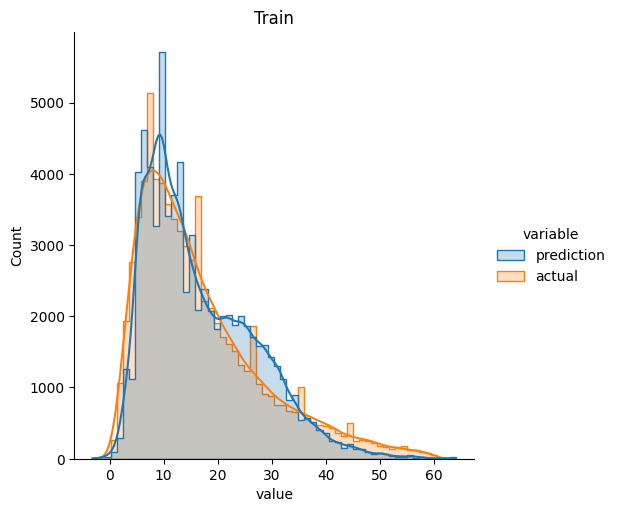

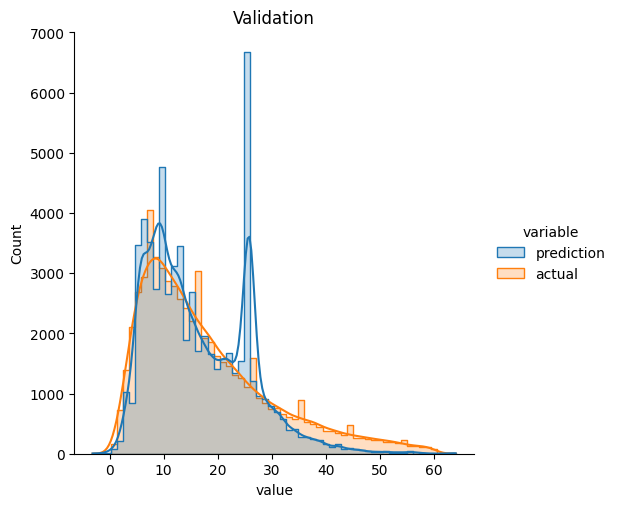

In [4]:
######### CODE FROM WEEK 1

df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val   = read_dataframe('./data/green_tripdata_2021-02.parquet')

target = 'duration'
df_train = df_train.with_columns(pl.concat_str(
                                  ['PULocationID','DOLocationID'],
                                     separator="_").alias('PU_DO'))
df_val = df_val.with_columns(pl.concat_str(
                                  ['PULocationID','DOLocationID'],
                                     separator="_").alias('PU_DO'))
categorical = ['PU_DO']
numerical = ['trip_distance']

linreg, dv, data = train(df_train, df_val, categorical, numerical, target)

with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, linreg), f_out)

We can then track an Experiment run. We track the relevant information using three mlflow commands ```set_tag```, ```log_param```, ```log_metric```

In [5]:
from sklearn.linear_model import Lasso


with mlflow.start_run():
    # Metadata tags (author name)
    mlflow.set_tag("developer","bokatan") 
    
    # Logging model parameters (training and validation sets)
    mlflow.log_param("train-data-path", 
                     "data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", 
                     "data/green_tripdata_2021-02.parquet")
    
    alpha = 0.1
    # Logging model parameters (Lasso's alpha)
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(data["X_train"], data["y_train"])
    
    y_pred = lr.predict(data["X_val"])
    rmse = mean_squared_error(data["y_val"], y_pred,
                              squared=False)
    
    # Logging model metrics (RMSE)
    mlflow.log_metric("rmse", rmse)

In the MLflow UI, within the nyc-taxi-experiment, we now have a run logged with our logged parameters, tag, and metric.

![nyc-taxi-experiment](images/mlflow2.png)

## Hyperparameter tuning with MLflow (MLflow Tracking)

Hyperparameter optimization of an XGBoost model with ```hyperopt``` library.

In [5]:
import xgboost as xgb

# Library for hyperparameter optimization
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

# Converting to data format required by XGBoost (optimized for both 
# memory efficiency and training speed)
train = xgb.DMatrix(data["X_train"], label=data["y_train"])
valid = xgb.DMatrix(data["X_val"], label=data["y_val"])

This function is responsible for training an XGBoost model with the  ```params``` hyperparameters

In [11]:
def objective(params):
    with mlflow.start_run(): # <-- new experiment run 
        mlflow.set_tag("model", "xgboost") 
        mlflow.log_params(params) # <-- # logging model hyperparameters
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')], # <-- val set for evaluation
            early_stopping_rounds=20
        )
        y_pred = booster.predict(valid)  # <-- predict on the val data
        rmse = mean_squared_error(data["y_val"], y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)  # <-- logging model metrics
        return {'loss': rmse, 'status': STATUS_OK}
# STATUS_OK is a constant that represents the status of a successful
# evaluation in hyperopt

Here we define the search space for hyperparameter optimization

In [12]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42 # random seed for reproducibility
}

where:
- ```scope``` is used to define the scope of a hyperparameter, such as
    specifying the type and range of values.
- ```hp``` defines various hyperparameter search spaces and distributions.
    In this case, we use uniform and log-uniform distributions over a
    range of values.
- ```reg_lambda``` is the L2 regularization term
- ```reg_alpha``` is the L1 regularization term
- ```min_child_weight``` refers to the minimum amount of information required to create a new leaf in the tree. Higher values lead to more conservative tree growth and can help control overfitting. On the other hand, a lower value allows for more detailed splits, potentially capturing more specific patterns in the data but increasing the risk of overfitting.
- ```reg:linear``` indicates that the objective of the XGBoost model is regression with a linear loss function.

Now we perform hyperparameter optimization using ```fmin``` (it will minimize the loss function by searching the hyperparameter space). 

By using the Tree of Parzen Estimators (TPE) algorithm, the ```fmin``` function intelligently suggests the next set of hyperparameters to evaluate (probabilistic model). It is based on the concept of Bayesian optimization. It balances between trying hyperparameters that have shown promise in the past (exploitation) and exploring new possibilities (exploration). Eventually, it narrows down the search space and suggests hyperparameters that have shown the best performance so far.

In [13]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=25,   # <-- max number of iterations for the hyperparameter search
    trials=Trials() # <-- holds the information and results of each iteration
)

[20:03:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.40609                                                    
[1]	validation-rmse:17.81733                                                    
[2]	validation-rmse:16.41042                                                    
[3]	validation-rmse:15.16285                                                    
[4]	validation-rmse:14.05719                                                    
[5]	validation-rmse:13.08745                                                    
[6]	validation-rmse:12.23080                                                    
[7]	validation-rmse:11.48098                                                    
[8]	validation-rmse:10.82696                                                    
[9]	validation-rmse:10.25560                                                    
[10]	validation-rmse:9.75223                                           

[98]	validation-rmse:6.46395                                                    
[99]	validation-rmse:6.46263                                                    
[20:03:25] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.94981                                                    
[1]	validation-rmse:17.02011                                                    
[2]	validation-rmse:15.36388                                                    
[3]	validation-rmse:13.94972                                                    
[4]	validation-rmse:12.74545                                                    
[5]	validation-rmse:11.72348                                                    
[6]	validation-rmse:10.86482                                                    
[7]	validation-rmse:10.14321                                                    
[8]	validation-rmse:9.54125                                            

[96]	validation-rmse:6.51020                                                    
[97]	validation-rmse:6.50898                                                    
[98]	validation-rmse:6.50803                                                    
[99]	validation-rmse:6.50714                                                    
[20:03:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:12.25141                                                    
[1]	validation-rmse:8.61737                                                     
[2]	validation-rmse:7.31779                                                     
[3]	validation-rmse:6.85404                                                     
[4]	validation-rmse:6.68303                                                     
[5]	validation-rmse:6.60132                                                     
[6]	validation-rmse:6.56579                                            

[72]	validation-rmse:6.58679                                                    
[73]	validation-rmse:6.58549                                                    
[74]	validation-rmse:6.58504                                                    
[75]	validation-rmse:6.58337                                                    
[76]	validation-rmse:6.58277                                                    
[77]	validation-rmse:6.58247                                                    
[78]	validation-rmse:6.58147                                                    
[79]	validation-rmse:6.58054                                                    
[80]	validation-rmse:6.58013                                                    
[81]	validation-rmse:6.57903                                                    
[82]	validation-rmse:6.57854                                                    
[83]	validation-rmse:6.57767                                                    
[84]	validation-rmse:6.57751

[70]	validation-rmse:6.47851                                                    
[71]	validation-rmse:6.47813                                                    
[72]	validation-rmse:6.47833                                                    
[73]	validation-rmse:6.47759                                                    
[74]	validation-rmse:6.47684                                                    
[75]	validation-rmse:6.47563                                                    
[76]	validation-rmse:6.47487                                                    
[77]	validation-rmse:6.47362                                                    
[78]	validation-rmse:6.47353                                                    
[79]	validation-rmse:6.47265                                                    
[80]	validation-rmse:6.47202                                                    
[81]	validation-rmse:6.47096                                                    
[82]	validation-rmse:6.47008

[68]	validation-rmse:6.48230                                                    
[69]	validation-rmse:6.48186                                                    
[70]	validation-rmse:6.48116                                                    
[71]	validation-rmse:6.48043                                                    
[72]	validation-rmse:6.47909                                                    
[73]	validation-rmse:6.47850                                                    
[74]	validation-rmse:6.47801                                                    
[75]	validation-rmse:6.47748                                                    
[76]	validation-rmse:6.47707                                                    
[77]	validation-rmse:6.47650                                                    
[78]	validation-rmse:6.47620                                                    
[79]	validation-rmse:6.47555                                                    
[80]	validation-rmse:6.47532

[20]	validation-rmse:6.66518                                                    
[21]	validation-rmse:6.66475                                                    
[22]	validation-rmse:6.66312                                                    
[23]	validation-rmse:6.66237                                                    
[24]	validation-rmse:6.65990                                                    
[25]	validation-rmse:6.65581                                                    
[26]	validation-rmse:6.65313                                                    
[27]	validation-rmse:6.65201                                                    
[28]	validation-rmse:6.64797                                                    
[29]	validation-rmse:6.64779                                                    
[30]	validation-rmse:6.64611                                                    
[31]	validation-rmse:6.64669                                                    
[32]	validation-rmse:6.64688

[45]	validation-rmse:7.04596                                                    
[46]	validation-rmse:7.00996                                                    
[47]	validation-rmse:6.97676                                                    
[48]	validation-rmse:6.94561                                                    
[49]	validation-rmse:6.91690                                                    
[50]	validation-rmse:6.88983                                                    
[51]	validation-rmse:6.86563                                                    
[52]	validation-rmse:6.84264                                                    
[53]	validation-rmse:6.82138                                                    
[54]	validation-rmse:6.80170                                                    
[55]	validation-rmse:6.78328                                                    
[56]	validation-rmse:6.76610                                                    
[57]	validation-rmse:6.74983

[43]	validation-rmse:6.60328                                                    
[44]	validation-rmse:6.60279                                                    
[45]	validation-rmse:6.60194                                                    
[46]	validation-rmse:6.60141                                                    
[47]	validation-rmse:6.60078                                                    
[48]	validation-rmse:6.59936                                                    
[49]	validation-rmse:6.59874                                                    
[50]	validation-rmse:6.59815                                                    
[51]	validation-rmse:6.59789                                                    
[52]	validation-rmse:6.59729                                                    
[53]	validation-rmse:6.59673                                                    
[54]	validation-rmse:6.59610                                                    
[55]	validation-rmse:6.59577

[41]	validation-rmse:6.50900                                                    
[42]	validation-rmse:6.50826                                                    
[43]	validation-rmse:6.50020                                                    
[44]	validation-rmse:6.49866                                                    
[45]	validation-rmse:6.49626                                                    
[46]	validation-rmse:6.49342                                                    
[47]	validation-rmse:6.49076                                                    
[48]	validation-rmse:6.49189                                                    
[49]	validation-rmse:6.49022                                                    
[50]	validation-rmse:6.49005                                                    
[51]	validation-rmse:6.48924                                                    
[52]	validation-rmse:6.48926                                                    
[53]	validation-rmse:6.48894

[50]	validation-rmse:6.52889                                                    
[51]	validation-rmse:6.52930                                                    
[52]	validation-rmse:6.52838                                                    
[53]	validation-rmse:6.52698                                                    
[54]	validation-rmse:6.52664                                                    
[55]	validation-rmse:6.52704                                                    
[56]	validation-rmse:6.52730                                                    
[20:05:23] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.41758                                                    
[1]	validation-rmse:11.79520                                                    
[2]	validation-rmse:9.60826                                                     
[3]	validation-rmse:8.33733                                            

[91]	validation-rmse:6.52256                                                    
[92]	validation-rmse:6.52228                                                    
[93]	validation-rmse:6.52192                                                    
[94]	validation-rmse:6.52168                                                    
[95]	validation-rmse:6.52125                                                    
[96]	validation-rmse:6.52082                                                    
[97]	validation-rmse:6.52073                                                    
[98]	validation-rmse:6.52066                                                    
[99]	validation-rmse:6.52017                                                    
[20:05:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:16.46675                                                    
[1]	validation-rmse:13.16988                                           

We can now see all the experiments in MLflow:

![nyc-taxi-experiment](images/mlflow3.png)

We can select all the runs and compare them:

![nyc-taxi-experiment](images/mlflow4.png)

We observe how different hyperparameters interact. For example, optimal values of rmse are associated with relatively low ```learning_rate``` and ```max_depth```, and low ```min_child_weight```.

![nyc-taxi-experiment](images/mlflow5.png)

We can also see the relations between the hyperparameters using scatterplots and contourplots.

![nyc-taxi-experiment](images/mlflow6.png)

Finally, to select the best model it's important to not only look at the lowest RMSE, but also considering the training time and model complexity (in this case represented by ```max_depth```). In our experiment, the three lowest RMSE are given by

| time | rmse | max_depth |
| --- | --- | --- |
| 2.9 | 6.418 | 11 |
| 4.3 | 6.419 | 23 |
| 7.9 | 6.45 | 47 |

We can conclude that the first row represent our best model. Therefore, we can extract the parameters and train the model individually.


In [15]:
params = {
    'learning_rate': 0.7004712434788133,
    'max_depth': 11,
    'min_child_weight': 3.779699515604052,
    'objective': 'reg:linear',
    'reg_alpha': 0.01678212993114507,
    'reg_lambda': 0.07474315195243142,
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')], # <-- val set for evaluation
        early_stopping_rounds=50
    )

2023/05/25 21:31:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c1e5f772761743e6b7d084e1d60bc4ec', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[21:31:11] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:9.59321
[1]	validation-rmse:7.20628
[2]	validation-rmse:6.77034
[3]	validation-rmse:6.67270
[4]	validation-rmse:6.64478
[5]	validation-rmse:6.63035
[6]	validation-rmse:6.62568
[7]	validation-rmse:6.61582
[8]	validation-rmse:6.61050
[9]	validation-rmse:6.60290
[10]	validation-rmse:6.59857
[11]	validation-rmse:6.59033
[12]	validation-rmse:6.58480
[13]	validation-rmse:6.57873
[14]	validation-rmse:6.57466
[15]	validation-rmse:6.57146
[16]	validation-rmse:6.56821
[17]	validation-rmse:6.56367
[18]	validation-rmse:6.56004
[19]	validation-rmse:6.55856
[20]	validation-rmse:6.55550
[21]	validation-rmse:6.55245
[22]	validation-rmse:6.55049
[23]	validation-rmse:6.54766
[24]	validation-rmse:6.54597
[25]	validation-rmse:6.54230
[26]	validation-rmse:6.53942
[27]	validation-rmse:6.53642
[28]	validation-rmse:6.53061
[29]	validation-rmse:6.52512
[30]	validation-rmse:

[273]	validation-rmse:6.37434
[274]	validation-rmse:6.37338
[275]	validation-rmse:6.37355
[276]	validation-rmse:6.37468


2023/05/25 21:31:24 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2023/05/25 21:31:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/javi/miniconda3/envs/mlops-zoomcamp/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In the previous code, instead of logging the parameters manually by specifiying the logged parameters and passing them as follows

```
with mlflow.start_run(): 
       mlflow.set_tag("model", "xgboost") 
       mlflow.log_params(params)
```

we used the Autologging feature in MLflow. There are two ways to use Autologging; First by enabling it globally using

```mlflow.autolog()```

or by enabling the framework-specific autologger; e.g., with XGBoost:

```mlflow.xgboost.autolog()```

The autologger then not only stores the model parameters for ease of use, it also stores other files inside the mlruns folder (conda.yaml, requirements.txt,...):

![nyc-taxi-experiment](images/mlflow7.png)

## Model management with MLflow (MLflow Models)

So far we have seen Experiment tracking, which is the iterative phase when you try many things to get your model performance to the level you need. 

The next step is Model management:
- streamlines moving models from experimentation to production
- helps with model versioning
- organizes model artifacts in an ML model registry
- helps with testing various model versions in the production environment
- enables rolling back to an old model version

![nyc-taxi-experiment](images/model_management.png)

### Model logging (versioning)

#### Approach 0

Use of ```mlflow.xgboost.autolog()``` as seen previously.

#### Approach 1

The simplest approach is to use Folder-based versioning. However, this comes with a series of drawbacks

- Error prone: e.g. accidentally overwriting older models
- No real versioning
- No lineage: no information on which data version that the model is derived from or the hyperparameters that it uses, ...

This is the approach we used when saving the linear model as a pickle file. We can then make this model accessible to MLflow by logging it as an artifact. To the previous code, we append the line ```mlflow.log_artifact```

```
from sklearn.linear_model import Lasso

with mlflow.start_run():
    ...
   mlflow.log_artifact(local_path='models/lin_reg.bin',
                       artifact_path='models_pickle')
```
#### Approach 2

Adapting from our previous XGBoost model, we will save the model as an artifact into MLflow and log the parameters manually. We will also log the original DictVectorizer preprocessor as an artifact.

In [6]:
# best model hyperparameters
params = {
    'learning_rate': 0.7004712434788133,
    'max_depth': 11,
    'min_child_weight': 3.779699515604052,
    'objective': 'reg:linear',
    'reg_alpha': 0.01678212993114507,
    'reg_lambda': 0.07474315195243142,
    'seed': 42
}

# turn off the autolog to avoid logging the model twice
mlflow.xgboost.autolog(disable=True)

with mlflow.start_run():
    # log our best model hyperparameters
    mlflow.log_params(params)
    booster = xgb.train(
                    params=params,
                    dtrain=train,
                    num_boost_round=1000,
                    evals=[(valid, 'validation')],
                    early_stopping_rounds=50
                )
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(data["y_val"], y_pred, squared=False)
    # log rmse
    mlflow.log_metric("rmse", rmse)
    # log xgboost model
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")
    # log the preprocessor DictVectorizer
    with open("models/preprocessor.bin", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.bin", 
                        artifact_path="preprocessor")

[12:39:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:9.59321
[1]	validation-rmse:7.20628
[2]	validation-rmse:6.77034
[3]	validation-rmse:6.67270
[4]	validation-rmse:6.64478
[5]	validation-rmse:6.63035
[6]	validation-rmse:6.62568
[7]	validation-rmse:6.61582
[8]	validation-rmse:6.61050
[9]	validation-rmse:6.60290
[10]	validation-rmse:6.59857
[11]	validation-rmse:6.59033
[12]	validation-rmse:6.58480
[13]	validation-rmse:6.57873
[14]	validation-rmse:6.57466
[15]	validation-rmse:6.57146
[16]	validation-rmse:6.56821
[17]	validation-rmse:6.56367
[18]	validation-rmse:6.56004
[19]	validation-rmse:6.55856
[20]	validation-rmse:6.55550
[21]	validation-rmse:6.55245
[22]	validation-rmse:6.55049
[23]	validation-rmse:6.54766
[24]	validation-rmse:6.54597
[25]	validation-rmse:6.54230
[26]	validation-rmse:6.53942
[27]	validation-rmse:6.53642
[28]	validation-rmse:6.53061
[29]	validation-rmse:6.52512
[30]	validation-rmse:

[273]	validation-rmse:6.37434
[274]	validation-rmse:6.37338
[275]	validation-rmse:6.37355
[276]	validation-rmse:6.37468
[277]	validation-rmse:6.37458


/home/javi/miniconda3/envs/mlops-zoomcamp/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


We can see that our run has been saved, along with the parameters and metrics that we have manually logged. Under the artifacts, we have ```models_mlflow``` and ```preprocessor``` that were saved

![nyc-taxi-experiment](images/mlflow8.png)

Once the model has been successfully trained, we can load the model from MLflow in our notebook. MLflow actually offers some premade code samples next to the ```Artifacts``` tab. We can copy the suggested example and load the model either as a ```PyFuncModel``` or ```xgboost``` model:

In [7]:
# Unique ID associated with our saved model
logged_model = 'runs:/47c9c0181f6a4a69b35f7248a6a3a3a2/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
# Load model as a xgboost.
xgb_model = mlflow.xgboost.load_model(logged_model)

2023/05/26 12:53:21 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


[12:53:21] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:21] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [8]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 47c9c0181f6a4a69b35f7248a6a3a3a2

In [9]:
xgb_model

## Model Registry (MLflow Registry)

The Model Registry is a system that allows machine learning engineers and data scientists to publish, test, monitor, govern and share them for collaboration with other teams. Essentially, the model registry is used when you’re done with your experimentation phase, and ready to share with the team and stakeholders.

We have seen how MLflow Tracking follows all the experiment runs, and used MLflow Models to save the results either with ```mlflow.autolog``` or ```mlflow.log_artifact``` or ```mlflow.log_model```. When any of these runs is production-ready, it's sent to MLflow Registry.

![nyc-taxi-experiment](images/mlflow9.png)

MLflow Registry allows to assign the registered model to any of stages - Stage, Production and Archive. Model Registry does not perform the deployment of the model, but it merely is a registry where we label the versions and the stages of the model. To deploy the model, we will require to implement CI/CD to communicate with Model Registry.

Let's go back to the best 3 xgboost models discussed previously and decide which model will be used for production. But first let's log the results for each of them using ```mlflow.autolog```

In [12]:
params1 = {
    'learning_rate': 0.7004712434788133,
    'max_depth': 11,
    'min_child_weight': 3.779699515604052,
    'objective': 'reg:linear',
    'reg_alpha': 0.01678212993114507,
    'reg_lambda': 0.07474315195243142,
    'seed': 42
}

params2 = {
'learning_rate':0.3147283275181539,
'max_depth':23,
'min_child_weight':3.1260549078187148,
'objective': 'reg:linear',
'reg_alpha':0.1085453455075964,
'reg_lambda':0.029688684707349613,
'seed': 42
}

params3 = {
'learning_rate':0.10484883676325818,
'max_depth':47,
'min_child_weight':2.0760652978943597,
'objective': 'reg:linear',
'reg_alpha':0.24115917550104224,
'reg_lambda':0.002689795200474687,
'seed': 42
}

params_all = (params1,params2,params3)

for i in params_all:

    mlflow.xgboost.autolog()

    with mlflow.start_run():
        booster = xgb.train(
                        params=i,
                        dtrain=train,
                        num_boost_round=1000,
                        evals=[(valid, 'validation')],
                        early_stopping_rounds=50
                )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(data["y_val"], y_pred, squared=False)

[13:57:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:9.59321
[1]	validation-rmse:7.20628
[2]	validation-rmse:6.77034
[3]	validation-rmse:6.67270
[4]	validation-rmse:6.64478
[5]	validation-rmse:6.63035
[6]	validation-rmse:6.62568
[7]	validation-rmse:6.61582
[8]	validation-rmse:6.61050
[9]	validation-rmse:6.60290
[10]	validation-rmse:6.59857
[11]	validation-rmse:6.59033
[12]	validation-rmse:6.58480
[13]	validation-rmse:6.57873
[14]	validation-rmse:6.57466
[15]	validation-rmse:6.57146
[16]	validation-rmse:6.56821
[17]	validation-rmse:6.56367
[18]	validation-rmse:6.56004
[19]	validation-rmse:6.55856
[20]	validation-rmse:6.55550
[21]	validation-rmse:6.55245
[22]	validation-rmse:6.55049
[23]	validation-rmse:6.54766
[24]	validation-rmse:6.54597
[25]	validation-rmse:6.54230
[26]	validation-rmse:6.53942
[27]	validation-rmse:6.53642
[28]	validation-rmse:6.53061
[29]	validation-rmse:6.52512
[30]	validation-rmse:

[273]	validation-rmse:6.37434
[274]	validation-rmse:6.37338
[275]	validation-rmse:6.37355
[276]	validation-rmse:6.37468


2023/05/26 13:57:47 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


[13:57:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.66363
[1]	validation-rmse:12.08583
[2]	validation-rmse:9.84307
[3]	validation-rmse:8.49744
[4]	validation-rmse:7.70842
[5]	validation-rmse:7.24737
[6]	validation-rmse:6.97988
[7]	validation-rmse:6.82368
[8]	validation-rmse:6.72297
[9]	validation-rmse:6.65946
[10]	validation-rmse:6.61612
[11]	validation-rmse:6.58911
[12]	validation-rmse:6.56774
[13]	validation-rmse:6.55553
[14]	validation-rmse:6.54774
[15]	validation-rmse:6.54311
[16]	validation-rmse:6.53504
[17]	validation-rmse:6.53017
[18]	validation-rmse:6.52570
[19]	validation-rmse:6.52250
[20]	validation-rmse:6.52000
[21]	validation-rmse:6.51732
[22]	validation-rmse:6.51223
[23]	validation-rmse:6.50914
[24]	validation-rmse:6.50726
[25]	validation-rmse:6.50473
[26]	validation-rmse:6.50165
[27]	validation-rmse:6.49980
[28]	validation-rmse:6.49770
[29]	validation-rmse:6.49657
[30]	validation-rms

[273]	validation-rmse:6.37140
[274]	validation-rmse:6.37150
[275]	validation-rmse:6.37148
[276]	validation-rmse:6.37122
[277]	validation-rmse:6.37113
[278]	validation-rmse:6.37104
[279]	validation-rmse:6.37083
[280]	validation-rmse:6.36993
[281]	validation-rmse:6.36976
[282]	validation-rmse:6.36982
[283]	validation-rmse:6.36982
[284]	validation-rmse:6.36997
[285]	validation-rmse:6.36990
[286]	validation-rmse:6.36989
[287]	validation-rmse:6.36967
[288]	validation-rmse:6.36986
[289]	validation-rmse:6.36975
[290]	validation-rmse:6.36974
[291]	validation-rmse:6.36973
[292]	validation-rmse:6.37039
[293]	validation-rmse:6.37040
[294]	validation-rmse:6.37043
[295]	validation-rmse:6.36986
[296]	validation-rmse:6.37004
[297]	validation-rmse:6.37004
[298]	validation-rmse:6.36996
[299]	validation-rmse:6.36990
[300]	validation-rmse:6.36984
[301]	validation-rmse:6.36989
[302]	validation-rmse:6.36987
[303]	validation-rmse:6.36983
[304]	validation-rmse:6.37028
[305]	validation-rmse:6.37062
[306]	vali

2023/05/26 13:58:13 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


[13:58:14] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.31883
[1]	validation-rmse:17.66041
[2]	validation-rmse:16.19780
[3]	validation-rmse:14.90943
[4]	validation-rmse:13.77776
[5]	validation-rmse:12.78663
[6]	validation-rmse:11.92054
[7]	validation-rmse:11.16623
[8]	validation-rmse:10.51188
[9]	validation-rmse:9.94382
[10]	validation-rmse:9.45559
[11]	validation-rmse:9.03520
[12]	validation-rmse:8.67453
[13]	validation-rmse:8.36554
[14]	validation-rmse:8.10128
[15]	validation-rmse:7.87671
[16]	validation-rmse:7.68589
[17]	validation-rmse:7.52219
[18]	validation-rmse:7.38371
[19]	validation-rmse:7.26592
[20]	validation-rmse:7.16508
[21]	validation-rmse:7.07791
[22]	validation-rmse:7.00409
[23]	validation-rmse:6.94058
[24]	validation-rmse:6.88514
[25]	validation-rmse:6.83768
[26]	validation-rmse:6.79629
[27]	validation-rmse:6.76097
[28]	validation-rmse:6.73032
[29]	validation-rmse:6.70291
[30]	validat

[273]	validation-rmse:6.39814
[274]	validation-rmse:6.39770
[275]	validation-rmse:6.39767
[276]	validation-rmse:6.39744
[277]	validation-rmse:6.39730
[278]	validation-rmse:6.39701
[279]	validation-rmse:6.39693
[280]	validation-rmse:6.39681
[281]	validation-rmse:6.39665
[282]	validation-rmse:6.39648
[283]	validation-rmse:6.39646
[284]	validation-rmse:6.39625
[285]	validation-rmse:6.39588
[286]	validation-rmse:6.39566
[287]	validation-rmse:6.39576
[288]	validation-rmse:6.39575
[289]	validation-rmse:6.39557
[290]	validation-rmse:6.39554
[291]	validation-rmse:6.39546
[292]	validation-rmse:6.39528
[293]	validation-rmse:6.39509
[294]	validation-rmse:6.39488
[295]	validation-rmse:6.39485
[296]	validation-rmse:6.39459
[297]	validation-rmse:6.39455
[298]	validation-rmse:6.39448
[299]	validation-rmse:6.39425
[300]	validation-rmse:6.39419
[301]	validation-rmse:6.39397
[302]	validation-rmse:6.39394
[303]	validation-rmse:6.39391
[304]	validation-rmse:6.39352
[305]	validation-rmse:6.39327
[306]	vali

[547]	validation-rmse:6.37792
[548]	validation-rmse:6.37778
[549]	validation-rmse:6.37783
[550]	validation-rmse:6.37785
[551]	validation-rmse:6.37776
[552]	validation-rmse:6.37789
[553]	validation-rmse:6.37788
[554]	validation-rmse:6.37779
[555]	validation-rmse:6.37770
[556]	validation-rmse:6.37773
[557]	validation-rmse:6.37781
[558]	validation-rmse:6.37771
[559]	validation-rmse:6.37775
[560]	validation-rmse:6.37775
[561]	validation-rmse:6.37774
[562]	validation-rmse:6.37772
[563]	validation-rmse:6.37752
[564]	validation-rmse:6.37740
[565]	validation-rmse:6.37740
[566]	validation-rmse:6.37747
[567]	validation-rmse:6.37750
[568]	validation-rmse:6.37740
[569]	validation-rmse:6.37745
[570]	validation-rmse:6.37743
[571]	validation-rmse:6.37737


2023/05/26 13:59:01 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


We can see how the models have been saved

![nyc-taxi-experiment](images/mlflow10.png)

The models summary:

| time | rmse | max_depth | Size |
| --- | --- | --- | --- |
| 14.6 | 6.365 | 11 |  611.68KB  |
| 25.9 | 6.368 | 23 |  2.35MB  |
| 48.5 | 6.377 | 47 |  8.95MB  |


### Registering Model

We will register 2 of the runs to the Model Registry. To do so, for each individual run, we click on the Register Model button:

![nyc-taxi-experiment](images/mlflow11.png)

As we have not registered a model before, we will need to Create New Model (we will name it ```nyctaxi_tripduration_regressor```):

![nyc-taxi-experiment](images/mlflow12.png)

Once we have registered all the models (under ```nyctaxi_tripduration_regressor```), we can see that the icons under the "Models" column (back in the "Experiments" tab) for the runs have changed:

![nyc-taxi-experiment](images/mlflow13.png)

If we click on the "Models" tab and on the ```nyctaxi_tripduration_regressor```, we can see the different versions of the model. The versions are automatically numbered by MLflow based on the sequence of when we registered the runs (we have also added a description):

![nyc-taxi-experiment](images/mlflow14.png)

### Transitioning Model Versions

Back in the main page of the Models tab, we can transition each of these Versions to different stages either using MLflow UI or MLflow API in Python.

For now let's transition Version 1 to "Production" stage while the other remaining versions will reside in "Staging" using MLflow UI. To do so, we click on each of the version and select the stage to transition it into

![nyc-taxi-experiment](images/mlflow15.png)

Once we have done that for the others, we can see on the main screen that we have all three versions have their own corresponding stages:

![nyc-taxi-experiment](images/mlflow16.png)

### Using MLflow Registry API 

We can do the same via the Python API. 

We will use MLflowClient in Python in order to communicate with our model

In [16]:
from mlflow.tracking import MlflowClient

# instantiate the client
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

We can search for runs by ascending order of metric score using the API by:

In [18]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='1',    # Experiment ID we want
    filter_string="metrics.rmse < 7",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
)

for run in runs:
    print(f"run id: {run.info.run_id}, \
          rmse: {run.data.metrics['rmse']:.4f}")

run id: 86a91235283c4bd6b7ba3b0aaf1aedfc,           rmse: 6.4176
run id: 736e787656be4fa59dad88bc8aada079,           rmse: 6.4190
run id: e29f8995d73c4bb3b80940dd5fa94bfd,           rmse: 6.4503
run id: f1457ee639cc43c195492be441fa8b22,           rmse: 6.4531
run id: 49ce02ae111048ec90c2b420218e72e5,           rmse: 6.4626


Say we want to register the run ```c67c06c6a0424b17904d60afeb9339b6``` in the Model Registry (the only saved model not previously registered).

In [19]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# set up variables
RUN_ID = "c67c06c6a0424b17904d60afeb9339b6"
MODEL_URI = f"runs:/{RUN_ID}/model"

But first let's ensure that the run has not been registered:

In [20]:
assert client.search_model_versions(f"run_id = '{RUN_ID}'") == [], \
                                    "Run has been registered!"

Then we can register the model with the MODEL_URI (which is linked to the RUN ID and saved model)

In [21]:
mlflow.register_model(model_uri = MODEL_URI, 
                      name="nyctaxi_tripduration_regressor")

Registered model 'nyctaxi_tripduration_regressor' already exists. Creating a new version of this model...
2023/05/26 15:26:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: nyctaxi_tripduration_regressor, version 4
Created version '4' of model 'nyctaxi_tripduration_regressor'.


<ModelVersion: aliases=[], creation_timestamp=1685107563563, current_stage='None', description=None, last_updated_timestamp=1685107563563, name='nyctaxi_tripduration_regressor', run_id='c67c06c6a0424b17904d60afeb9339b6', run_link=None, source='/home/javi/PycharmProjects/mlops-zoomcamp/cohorts/2023/02-experiment-tracking/mlruns/1/c67c06c6a0424b17904d60afeb9339b6/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=4>

Now the new version has been added:

![nyc-taxi-experiment](images/mlflow17.png)

We will now transition the model to staging. Before we do that, let's find the latest versions

In [22]:
# get the latest versions
model_name = "nyctaxi_tripduration_regressor"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"Version: {version.version}, Stage: {version.current_stage}")

Version: 1, Stage: Production
Version: 2, Stage: Staging
Version: 4, Stage: None


Let's transition version 4 to "Staging"

In [23]:
version = 4
stage = "Staging"
client.transition_model_version_stage(
    name=model_name,
    version=version,
    stage=stage,
    archive_existing_versions=False
)

<ModelVersion: aliases=[], creation_timestamp=1685107563563, current_stage='Staging', description=None, last_updated_timestamp=1685107856423, name='nyctaxi_tripduration_regressor', run_id='c67c06c6a0424b17904d60afeb9339b6', run_link=None, source='/home/javi/PycharmProjects/mlops-zoomcamp/cohorts/2023/02-experiment-tracking/mlruns/1/c67c06c6a0424b17904d60afeb9339b6/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=4>

Now the stage has been updated:

![nyc-taxi-experiment](images/mlflow18.png)

## Configuring MLflow for different scenarios

We have seen that MLflow Tracking is organized around the concept of runs, which are executions of some piece of data science code. For storing these runs and their associated artifacts, MLflow uses two components for storage: 

- Backend store (runs, parameters, metrics, tags, notes, metadata, etc)
- Artifact store (files, models, images, in-memory objects, or model summary, etc)

The MLflow client can interface with a variety of backend and artifact storage configurations. Here are three common configuration scenarios:

#### Scenario 1: A single data scientist participating in an ML competition

- Backend store: local filesystem (information saved locally in a folder)
- Artifacts store: local filesystem
- Tracking server: no

The experiments can be explored locally by launching the MLflow UI.

In [1]:
import mlflow

print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'file:///home/javi/PycharmProjects/mlops-zoomcamp/cohorts/2023/02-experiment-tracking/mlruns'


We observe how everything is saved locally in the location above. In this scenario we cannot set up a model registry, as the backend store is not associated with a relational database (e.g. SQLite)

#### Scenario 2: A cross-functional team with one data scientist working on an ML model

- Backend store: sqlite database
- Artifacts store: local filesystem
- Tracking server: yes, local server (you can see the results of the runs in real time)

The experiments can be explored locally by accessing the local tracking server.

To run this example you need to launch the mlflow server locally by running the following command in your terminal:

```mlflow server --backend-store-uri sqlite:///backend.db default-artifact-root ./artifacts_local```

In [ ]:
import mlflow

# Address of the (local) tracking server by default
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# This will print the address defined above
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

The artifacts will be saved in ```./artifacts_local``` but the runs and metadata will be stored in the sqlite database (there will be a file ```backend.db``` specifying that sqlite has been used). In this scenario we can use the model registry.

#### Scenario 3: Multiple data scientists working on multiple ML models

- Backend store: postgresql database
- Artifacts store: AWS s3 bucket
- Tracking server: yes, remote server (AWS EC2)

The experiments can be explored by accessing the remote server. The different DS can run experiments and interact with the model registry in parallel.

The exampe uses AWS to host a remote server. In order to run the example you'll need an AWS account. Follow the steps described in the file ```mlflow_on_aws.md``` (located in the folder ```02-experiment-tracking```) to create a new AWS account and launch the tracking server.